In [3]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
import cv2
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans
from astropy.time import Time
import csv
from statistics import stdev
from statistics import mean
from matplotlib import pyplot as plt


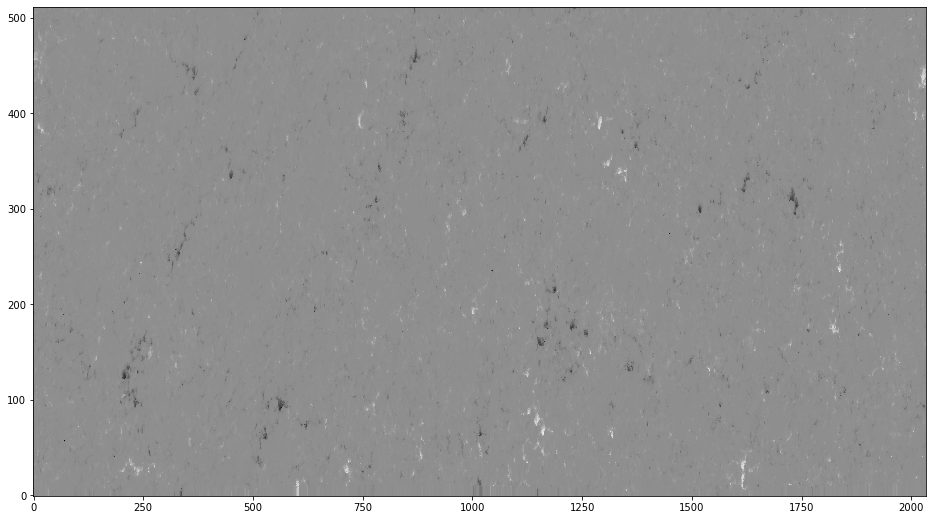

In [20]:
fda = np.array(range(-500, 500)).reshape(40, 25)

def normalgray(feature):
    
    feature = feature - feature.min()
    d = 1000 / (feature.max() - feature.min())
    feature = np.multiply(d, feature)
    feature = feature - 500
    return feature

    
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]

fileData = astropy.io.fits.open(NewList[0])
B = fileData[1].data
Binc = fileData[2].data
Bincfinal = np.cos(np.deg2rad(Binc))
fda = np.multiply(B, Bincfinal )
fda = normalgray(fda)
plt.figure(figsize = (16,9))
plt.imshow(fda, cmap='gray', aspect='auto', interpolation='nearest', origin='bottom')
plt.savefig('b&binc.png')

In [21]:
def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out


def pltci(filename):
    fileData = astropy.io.fits.open(filename)
    ci = fileData[32].data
    fda = normalgray(ci)
    v = filename[42:-5]
    plt.figure(figsize = (16,9))
    plt.imshow(fda, cmap='gray', aspect='auto', origin='bottom')
    plt.savefig('cigray'+'/'+ v + '.png')
    plt.close()
    

def pltb(filename):
    fileData = astropy.io.fits.open(filename)
    b = fileData[1].data
    b[b>2000]=2000
    b[b<200]=0
    fda = normalgray(b)
    v = filename[42:-5]
    plt.figure(figsize = (16,9))
    plt.imshow(fda, cmap='gray', aspect='auto', origin='bottom')
    plt.savefig('bgray'+'/'+ v + '.png')
    plt.close()

def pltdop(filename):
    fileData = astropy.io.fits.open(filename)
    dop = fileData[4].data
    fda = normalgray(canNoise(dop))
    v = filename[42:-5]
    plt.figure(figsize = (16,9))
    plt.imshow(fda, cmap='gray', aspect='auto', origin='bottom')
    plt.savefig('dopgray'+'/'+ v + '.png')
    plt.close()
    
  


In [22]:
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]


b = []

for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)

NewList = []       
NewList = b

for d in NewList:
    pltci(d)
    pltdop(d)
    pltb(d)

In [9]:
# Normalizing between [1,-1]
def normal(feature):
    feature = feature - feature.mean()
    feature = feature / feature.max()
    return feature

# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float64)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float64)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float64)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float64)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float64)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float64)


    return B, Binc, Bazi, DopF, SLFF, CI

# Getting different centroids

def getCenteroids(list):
    centroidsList = random.shuffle(list)
    return centroidsList


# Resizing Feature to 512*512
def res(img):
    resize = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    return resize

# Square and sum of elements in substracting matrix
def ss(mat):
    a = np.square(mat)
    b = np.sum(a)
    return b

# calculating Centroids

def CalCentroid(cluster):
    length = len(cluster)
    Bsum = np.zeros((512,512), dtype=np.float64)
    Bincsum = np.zeros((512,512), dtype=np.float64)
    Bazisum = np.zeros((512,512), dtype=np.float64)
    DopFsum = np.zeros((512,512), dtype=np.float64)
    DopSsum = np.zeros((512,512), dtype=np.float64)
    SLFFsum = np.zeros((512,512), dtype=np.float64)
    CIsum = np.zeros((512,512), dtype=np.float64)
    for i in cluster:
        file = ReadFits(i)
        B, Binc, Bazi, DopF, DopS, SLFF, CI = getFeatures(file)
        Bsum = np.add(Bsum, normal(res(B)))
        Bincsum = np.add(Bincsum, normal(res(Binc))) 
        Bazisum = np.add(Bazisum, normal(res(Bazi))) 
        DopFsum = np.add(DopFsum, normal(res(DopF))) 
        DopSsum = np.add(DopSsum, normal(res(DopS))) 
        SLFFsum = np.add(SLFFsum, normal(res(SLFF))) 
        CIsum = np.add(CIsum, normal(res(CI))) 
        
    BC = np.divide(Bsum, length) 
    BincC = np.divide(Bincsum, length) 
    BaziC = np.divide(Bazisum, length) 
    DopFC = np.divide(DopFsum, length) 
    DopSC = np.divide(DopSsum, length) 
    SLFFC = np.divide(SLFFsum, length) 
    CIC = np.divide(CIsum, length)
    
    return BC, BincC, BaziC, DopFC, DopSC, SLFFC, CIC


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(DopF, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out


# getting mean and max of features

def meanmax(feature):

    featuremean = feature.mean()
    featuremax = feature.max()
    return featuremean, featuremax

# Getting original values

def unnormalCenter(numpyarray):
    
    a = np.multiply(numpyarray[0], Btotmax)
    Bcen = np.add(a, Btotmean)
    
    b = np.arccos(numpyarray[1])
    Binccen = np.degrees(b)
    
    c = np.arccos(numpyarray[2])
    Bazicen = np.degrees(c)
    
    d = np.multiply(numpyarray[3], DopFtotmax)
    DopFcen = np.add(d, DopFtotmean)
    
    #e = np.multiply(numpyarray[4], DopStotmax)
    #DopScen = np.add(e, DopStotmean)
    
    f = np.multiply(numpyarray[4], SLFFtotmax)
    SLFFcen = np.add(f, SLFFtotmean)
    
    g = np.multiply(numpyarray[5], CItotmax)
    CIcen = np.add(g, CItotmean)
    
    return Bcen, Binccen, Bazicen, DopFcen, SLFFcen, CIcen 



# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a


# Plotting the image

def pltimg(array, dim, i):
    
    img_array = []
    for x in array:
        if x == 0:
            img_array.append((255,0,0)) # RED
        elif x == 1:
            img_array.append((128,128,0)) # OLIVE
        elif x == 2:
            img_array.append((0,255,0)) # GREEN
        elif x == 3:
            img_array.append((0,0,255)) # BLUE
        elif x == 4:
            img_array.append((255,255,255)) # BLACK
        elif x == 5:
            img_array.append((0,0,0)) # WHITE
        elif x == 6:
            img_array.append((128,0,128)) # PURPLE
        elif x == 7:
            img_array.append((0,128,128)) # TEAL
        elif x == 8:
            img_array.append((0,0,128)) # NAVY
        elif x == 9:
            img_array.append((128,0,0)) # MAROON
    
    fileData = astropy.io.fits.open(NewList[i])
    timestamp = fileData[0].header['TSTART']
    t =astropy.time.Time(timestamp)
    v = str(t.decimalyear)
    img = Image.new('RGB',dim)
    img.putdata(img_array)
    img.save('north/'+ v + '.png')



In [10]:
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]

# Making a list for dimensions of observations
dimList = list()

for i in NewList:
    
    file = astropy.io.fits.open(i)
    y, x = file[1].data.shape
    dimList.append((x, y))
    
    
    
Btot, Binctot, Bazitot, DopFtot, DopStot, SLFFtot, CItot = np.array([0]), np.array([0]),np.array([0]),\
                            np.array([0]),np.array([0]),np.array([0]),np.array([0])


for j in NewList:
    
    B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
    Btot = np.concatenate((Btot, B), axis=None)
    Binctot = np.concatenate((Binctot, Binc), axis=None)
    Bazitot = np.concatenate((Bazitot, Bazi), axis=None)
    DopFtot = np.concatenate((DopFtot, DopF), axis=None)
    #DopStot = np.concatenate((DopStot, canNoise(DopS)), axis=None)
    SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
    CItot = np.concatenate((CItot, CI), axis=None)
   




# features

Btot = np.delete(Btot, 0, None)
Binctot = np.delete(Binctot, 0, None)
Bazitot = np.delete(Bazitot, 0, None)
DopFtot = np.delete(DopFtot, 0, None)
#DopStot = np.delete(DopStot, 0, None)
SLFFtot = np.delete(SLFFtot, 0, None)
CItot = np.delete(CItot, 0, None)



Btotmean, Btotmax = meanmax(Btot)
#Binctotmean, Binctotmax = meanmax(Binctot)
#Bazitotmean, Bazitotmax = meanmax(Bazitot)
DopFtotmean, DopFtotmax = meanmax(Btot)
#DopStotmean, DopStotmax = meanmax(DopStot)
SLFFtotmean, SLFFtotmax = meanmax(SLFFtot)
CItotmean, CItotmax = meanmax(CItot)


In [22]:
dade = np.load('tenmeans.npy')

def stdmean(labels ):
    

    
    d = {i:[] for i in range(60)}
    for n, x in enumerate(labels):
        
        if x == 0:
            d[0].append(Btot[n])
            d[1].append(Binctot[n])
            d[2].append(Bazitot[n])
            d[3].append(DopFtot[n])
            d[4].append(SLFFtot[n])
            d[5].append(CItot[n])

        elif x == 1:
            d[6].append(Btot[n])
            d[7].append(Binctot[n])
            d[8].append(Bazitot[n])
            d[9].append(DopFtot[n])
            d[10].append(SLFFtot[n])
            d[11].append(CItot[n])
        elif x == 2:
            d[12].append(Btot[n])
            d[13].append(Binctot[n])
            d[14].append(Bazitot[n])
            d[15].append(DopFtot[n])
            d[16].append(SLFFtot[n])
            d[17].append(CItot[n])
        elif x == 3:
            d[18].append(Btot[n])
            d[19].append(Binctot[n])
            d[20].append(Bazitot[n])
            d[21].append(DopFtot[n])
            d[22].append(SLFFtot[n])
            d[23].append(CItot[n])
        elif x == 4:
            d[24].append(Btot[n])
            d[25].append(Binctot[n])
            d[26].append(Bazitot[n])
            d[27].append(DopFtot[n])
            d[28].append(SLFFtot[n])
            d[29].append(CItot[n])
        elif x == 5:
            d[30].append(Btot[n])
            d[31].append(Binctot[n])
            d[32].append(Bazitot[n])
            d[33].append(DopFtot[n])
            d[34].append(SLFFtot[n])
            d[35].append(CItot[n])
        elif x == 6:
            d[36].append(Btot[n])
            d[37].append(Binctot[n])
            d[38].append(Bazitot[n])
            d[39].append(DopFtot[n])
            d[40].append(SLFFtot[n])
            d[41].append(CItot[n])
        elif x == 7:
            d[42].append(Btot[n])
            d[43].append(Binctot[n])
            d[44].append(Bazitot[n])
            d[45].append(DopFtot[n])
            d[46].append(SLFFtot[n])
            d[47].append(CItot[n])
        elif x == 8:
            d[48].append(Btot[n])
            d[49].append(Binctot[n])
            d[50].append(Bazitot[n])
            d[51].append(DopFtot[n])
            d[52].append(SLFFtot[n])
            d[53].append(CItot[n])
        elif x == 9:
            d[54].append(Btot[n])
            d[55].append(Binctot[n])
            d[56].append(Bazitot[n])
            d[57].append(DopFtot[n])
            d[58].append(SLFFtot[n])
            d[59].append(CItot[n])
    # field names  
    fields = ['Cluster', 'Color', 'Bmean', 'Bstd','Bincmean', 'Bincstd', 'Bazimean', 'Bazistd', \
             'DopFmean', 'DopFstd', 'SLFFmean', 'SLFFstd', 'CImean', 'CIstd']  

    # data rows of csv file  
    rows = [ ['0', 'RED', mean(d[0]), stdev(d[0]), mean(d[1]), stdev(d[1]),  mean(d[2]), stdev(d[2]), mean(d[3]), stdev(d[3]), mean(d[4]), stdev(d[4]), mean(d[5]), stdev(d[5])],  
         ['1', 'OLIVE', mean(d[6]), stdev(d[6]), mean(d[7]), stdev(d[7]), mean(d[8]), stdev(d[8]), mean(d[9]), stdev(d[9]), mean(d[10]), stdev(d[10]), mean(d[11]), stdev(d[11])],  
         ['2', 'GREEN', mean(d[12]), stdev(d[12]), mean(d[13]), stdev(d[13]), mean(d[14]), stdev(d[14]), mean(d[15]), stdev(d[15]),  mean(d[16]), stdev(d[16]), mean(d[17]), stdev(d[17])],  
         ['3', 'BLUE', mean(d[18]), stdev(d[18]), mean(d[19]), stdev(d[19]), mean(d[20]), stdev(d[20]), mean(d[21]), stdev(d[21]),  mean(d[22]), stdev(d[22]), mean(d[23]), stdev(d[23])],  
         ['4', 'BLACK', mean(d[24]), stdev(d[24]), mean(d[25]), stdev(d[25]), mean(d[26]), stdev(d[26]), mean(d[27]), stdev(d[27]),  mean(d[28]), stdev(d[28]), mean(d[29]), stdev(d[29])],  
         ['5', 'WHITE', mean(d[30]), stdev(d[30]), mean(d[31]), stdev(d[31]), mean(d[32]), stdev(d[32]), mean(d[33]), stdev(d[33]),  mean(d[34]), stdev(d[34]), mean(d[35]), stdev(d[35])],
         ['6', 'PURPLE', mean(d[36]), stdev(d[36]), mean(d[37]), stdev(d[37]), mean(d[38]), stdev(d[38]), mean(d[39]), stdev(d[39]),  mean(d[40]), stdev(d[40]), mean(d[41]), stdev(d[41])],
         ['7', 'TEAL', mean(d[42]), stdev(d[42]), mean(d[43]), stdev(d[43]), mean(d[44]), stdev(d[44]), mean(d[45]), stdev(d[45]),  mean(d[46]), stdev(d[46]), mean(d[47]), stdev(d[47])],
         ['8', 'NAVY', mean(d[48]), stdev(d[48]), mean(d[49]), stdev(d[49]), mean(d[50]), stdev(d[50]), mean(d[51]), stdev(d[51]),  mean(d[52]), stdev(d[52]), mean(d[53]), stdev(d[53])],
         ['9', 'MAROON', mean(d[54]), stdev(d[54]), mean(d[55]), stdev(d[55]), mean(d[56]), stdev(d[56]), mean(d[57]), stdev(d[57]),  mean(d[58]), stdev(d[58]), mean(d[59]), stdev(d[59])]]  

    # name of csv file  
    filename = "10cluter-table.csv"

    # writing to csv file  
    with open(filename, 'w') as csvfile:  
        # creating a csv writer object  
        csvwriter = csv.writer(csvfile)  

        # writing the fields  
        csvwriter.writerow(fields)  

        # writing the data rows  
        csvwriter.writerows(rows) 
        
stdmean(dade)

NameError: name 'Btot' is not defined

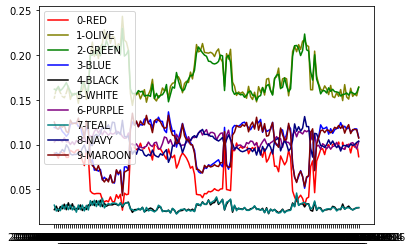

In [13]:
dade = np.load('tenmeans.npy')

start = 0
end = 0

v = {n:[] for n in range(10)}
xx = []

for s, tple in enumerate(dimList):
    
    endd = tple[0] * tple[1]
    
    end += tple[0] * tple[1]    
    
    array = dade[start:end]
    dim = tple
    
    a = b = c = d = e = f = g = h = i = j = 0

    for x in array:
        if x == 0:
            a += 1 # RED
        elif x == 1:
            b += 1 # OLIVE
        elif x == 2:
            c += 1 # GREEN
        elif x == 3:
            d += 1 # BLUE
        elif x == 4:
            e += 1  # BLACK
        elif x == 5:
            f += 1 # WHITE
        elif x == 6:
            g += 1 # PURPLE
        elif x == 7:
            h +=1 # TEAL
        elif x == 8:
            i +=1 # NAVY
        elif x == 9:
            j += 1 # MAROON
    
    
    v[0].append(a/endd)
    v[1].append(b/endd)
    v[2].append(c/endd)
    v[3].append(d/endd)
    v[4].append(e/endd)
    v[5].append(f/endd)
    v[6].append(g/endd)
    v[7].append(h/endd)
    v[8].append(i/endd)
    v[9].append(j/endd)
    
    start = end
    
    
    
    fileData = (NewList[s])
    xaxis= fileData[42:-5]
    xx.append(xaxis)

import math
import matplotlib.pyplot as plt


fig = plt.figure()
plt.plot(xx, v[0], 'red', label="0-RED")
plt.plot(xx, v[1], 'olive', label="1-OLIVE")
plt.plot(xx, v[2], 'green', label="2-GREEN")
plt.plot(xx, v[3], 'blue', label="3-BLUE")
plt.plot(xx, v[4], 'black', label="4-BLACK")
plt.plot(xx, v[5], 'white', label="5-WHITE")
plt.plot(xx, v[6], 'purple', label="6-PURPLE") 
plt.plot(xx, v[7], 'teal', label="7-TEAL") 
plt.plot(xx, v[8], 'navy', label="8-NAVY")
plt.plot(xx, v[9],  'maroon', label="9-MAROON")
plt.show()    
fig.savefig('plot11.png') 

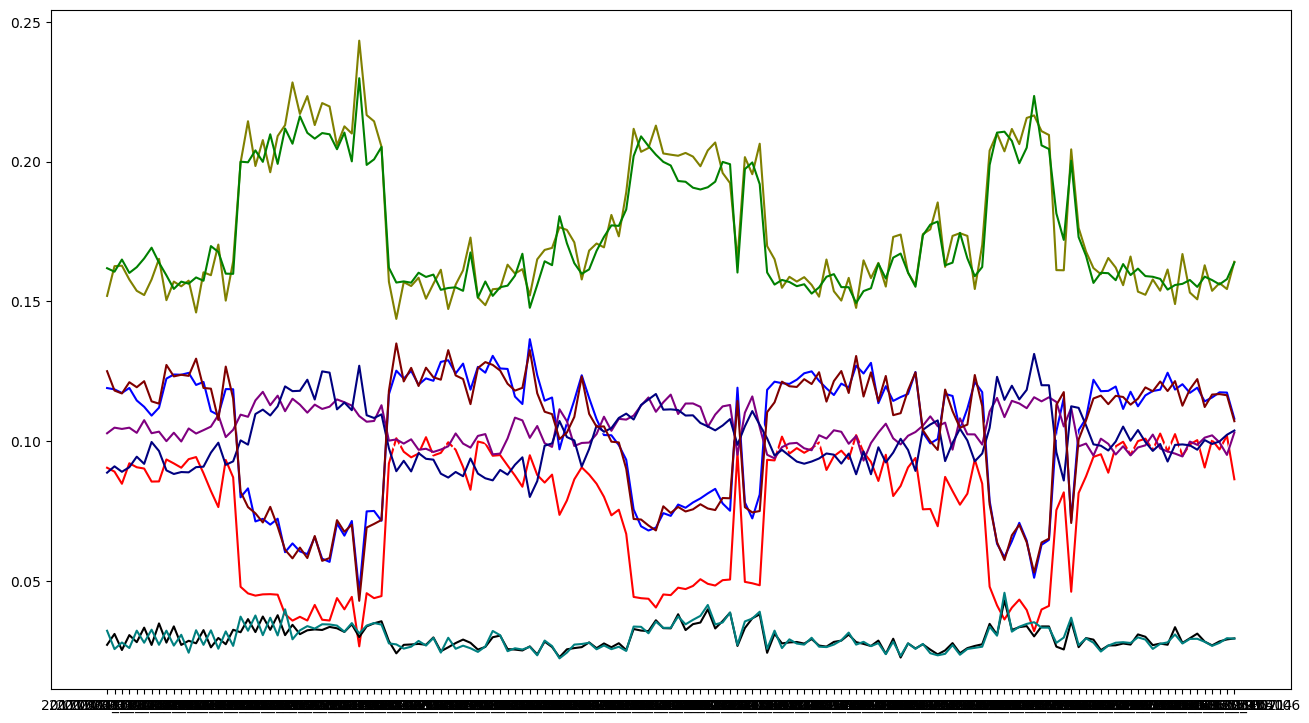

In [17]:
fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(xx, v[0], 'red', label="0-RED")
plt.plot(xx, v[1], 'olive', label="1-OLIVE")
plt.plot(xx, v[2], 'green', label="2-GREEN")
plt.plot(xx, v[3], 'blue', label="3-BLUE")
plt.plot(xx, v[4], 'black', label="4-BLACK")
plt.plot(xx, v[5], 'white', label="5-WHITE")
plt.plot(xx, v[6], 'purple', label="6-PURPLE") 
plt.plot(xx, v[7], 'teal', label="7-TEAL") 
plt.plot(xx, v[8], 'navy', label="8-NAVY")
plt.plot(xx, v[9],  'maroon', label="9-MAROON")
plt.show()    
fig.savefig('plot11.png') 

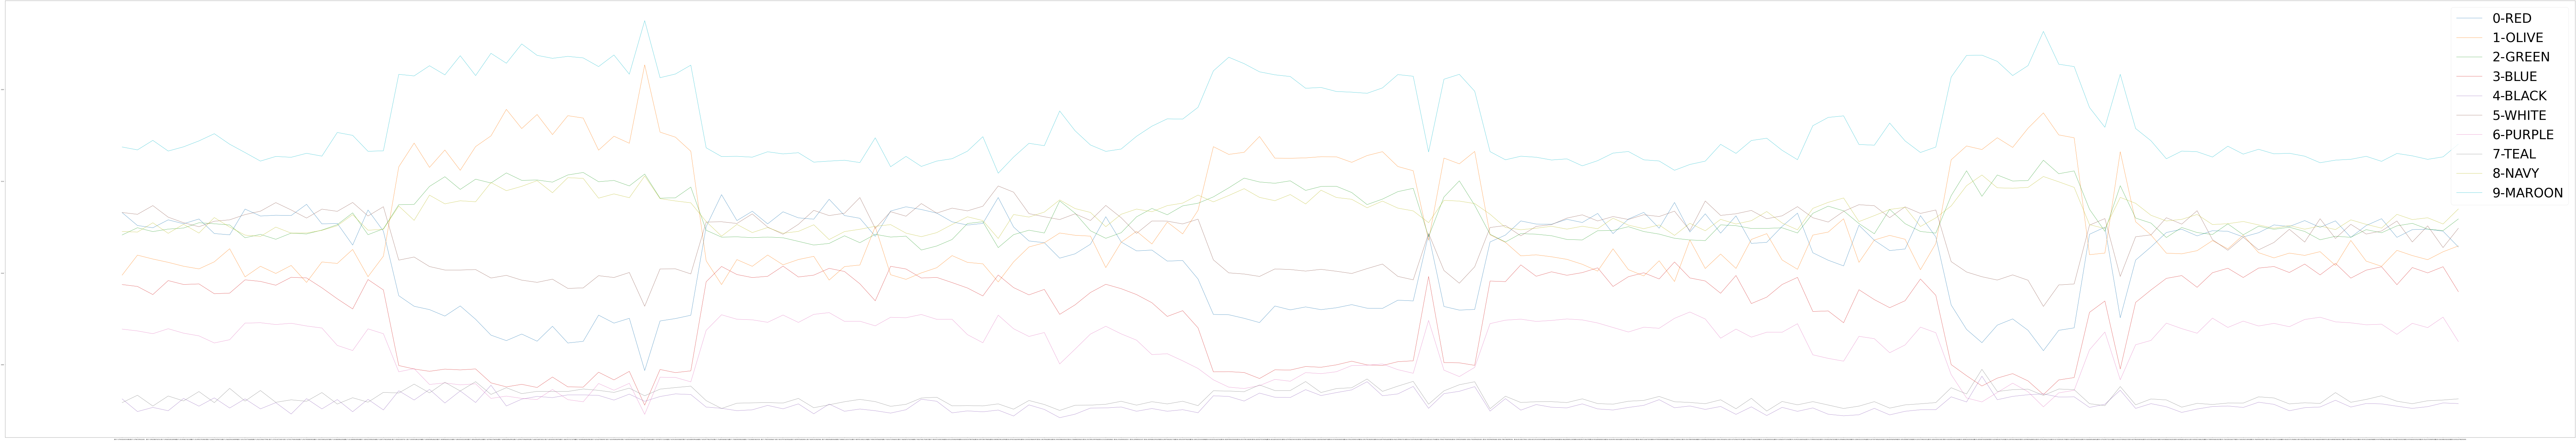

In [61]:
fig = plt.figure(figsize=(315,55), dpi=30)
plt.plot(xx, v[0], label="0-RED")
plt.plot(xx, v[1], label="1-OLIVE")
plt.plot(xx, v[2], label="2-GREEN")
plt.plot(xx, v[3], label="3-BLUE")
plt.plot(xx, v[4], label="4-BLACK")
plt.plot(xx, v[5], label="5-WHITE")
plt.plot(xx, v[6], label="6-PURPLE") 
plt.plot(xx, v[7], label="7-TEAL") 
plt.plot(xx, v[8], label="8-NAVY")
plt.plot(xx, v[9], label="9-MAROON")
plt.legend(loc=1, prop={'size': 88})
plt.show()    
fig.savefig('plot1.png')

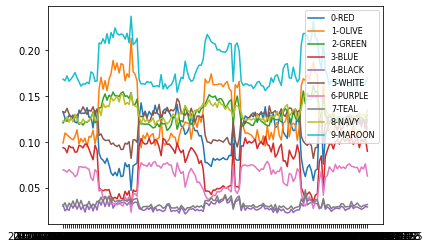

In [49]:
fig = plt.figure()
plt.plot(xx, v[0], label="0-RED")
plt.plot(xx, v[1], label="1-OLIVE")
plt.plot(xx, v[2], label="2-GREEN")
plt.plot(xx, v[3], label="3-BLUE")
plt.plot(xx, v[4], label="4-BLACK")
plt.plot(xx, v[5], label="5-WHITE")
plt.plot(xx, v[6], label="6-PURPLE") 
plt.plot(xx, v[7], label="7-TEAL") 
plt.plot(xx, v[8], label="8-NAVY")
plt.plot(xx, v[9], label="9-MAROON")
plt.legend(loc=1, prop={'size': 8})
plt.show()
fig.savefig('plot1.png')

In [16]:
a


[0.3]

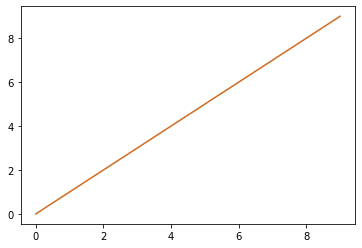

In [35]:
a = np.arange(10)
plt.plot(a, 'chocolate')

In [35]:
x1 = np.arange(9.0).reshape((3, 3))
print(x1)
x2 = np.array(range(-9, 0)).reshape((3,3))
print(x2)
x2-2

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[-9 -8 -7]
 [-6 -5 -4]
 [-3 -2 -1]]


array([[-11, -10,  -9],
       [ -8,  -7,  -6],
       [ -5,  -4,  -3]])

In [28]:
 - 0 == 0

True

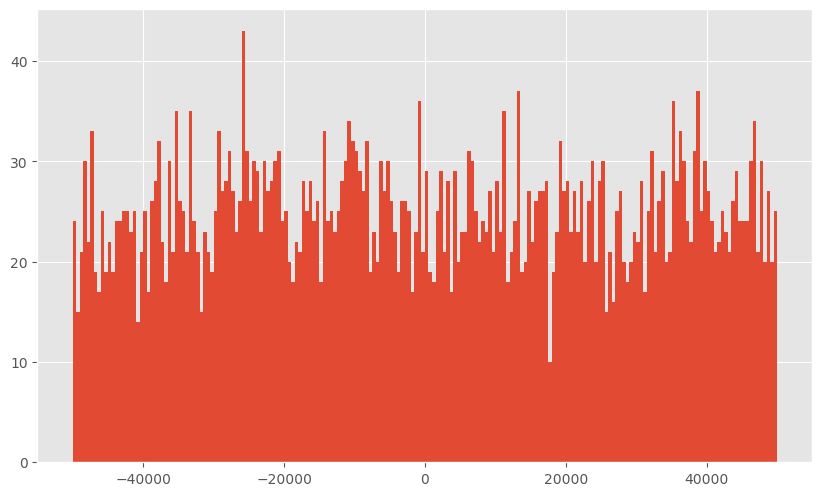

In [24]:

import math
import matplotlib.pyplot as plt
import random
#Generate 5 random numbers between 10 and 30
fig = plt.figure(figsize=(10,6), dpi=100)
x = random.sample(range(-50000, 50000), 5000)
plt.style.use('ggplot')
plt.hist(x, bins=200)
fig.savefig('plottest.png') 